In [ ]:
pip install pandas-datareader

In [ ]:
#General
import numpy as np
import pandas as pd
import pandas_profiling as pp
import math
import datetime
#Data Retrieval and Visualization
import pandas_datareader
import pandas_datareader.data as web
import matplotlib.pyplot as plt #2
import os
#import blpapi
#from xbbg import blp
%matplotlib inline
import seaborn as sn
#Model
from scipy import stats 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# **SIMPLE TEST**

In [ ]:
NASDAQ=pandas_datareader.nasdaq_trader.get_nasdaq_symbols()

In [ ]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2020, 1, 27)
AAPL=web.DataReader("AAPL",'yahoo',start,end)
AA=web.DataReader("AA",'yahoo',start,end)
FORD=web.DataReader("FORD",'yahoo',start,end)
TSLA=web.DataReader("TSLA",'yahoo',start,end)
NFLX=web.DataReader("NFLX",'yahoo',start,end)

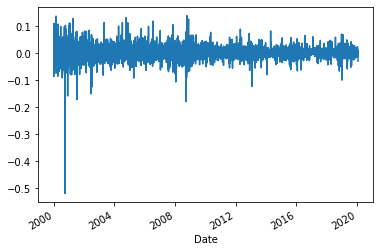

In [ ]:
AAPL['Adj Close'].pct_change().plot()

## **Metrics**

In [ ]:
def MaxDrawdown(trading_days, return_list): #Risk management
    '''return_list is a 1-Dimension list or np.array'''
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])  
    Max_Drawdown_Rate = (return_list[j] - return_list[i]) / (return_list[j])  
    plt.plot(trading_days, return_list)
    plt.title("Max Drawdown", color='k', size=15)
    plt.xlabel("Date", size=10)
    plt.ylabel("Net Worth", size=10)
    plt.plot([trading_days[i], trading_days[j]], [return_list[i], return_list[j]], 'o', color="r", markersize=10)
    plt.legend()
    plt.grid(True)
    plt.show()
    return Max_Drawdown_Rate
def SharpeRatio(returns): #Risk adjusted return mean/std
    #Formula=[E(Rp)－Rf]/σp
    #returns = (return_list[1:]-return_list[:-1])/return_list[:-1]   
    average_return = np.mean(returns)
    return_stdev = np.std(returns)
    AnnualRet = average_return*252              
    AnnualVol = return_stdev*np.sqrt(252)       
    sharpe_ratio = (AnnualRet-0.015) /AnnualVol  #Annualized Rf=0.015
    return sharpe_ratio
# load in the backtest dataset. Its just the basics, you can add more if required

## **Backtesting Single Name Equity**

### **Rebalancing Period**

In [ ]:
#Specified Format ? Daily, Monthly ,...
#Ex: Resample Daily to Monthly Data
AAPL_M=AAPL.resample('M').agg({'Open':'first', 'High':'max','Low': 'min', 'Close':'last','Adj Close':'last','Volume':'mean'})
AA_M=AA.resample('M').agg({'Open':'first', 'High':'max','Low': 'min', 'Close':'last','Adj Close':'last','Volume':'mean'})
FORD_M=FORD.resample('M').agg({'Open':'first', 'High':'max','Low': 'min', 'Close':'last','Adj Close':'last','Volume':'mean'})
TSLA_M=TSLA.resample('M').agg({'Open':'first', 'High':'max','Low': 'min', 'Close':'last','Adj Close':'last','Volume':'mean'})
NFLX_M=NFLX.resample('M').agg({'Open':'first', 'High':'max','Low': 'min', 'Close':'last','Adj Close':'last','Volume':'mean'})
list_stock=[AAPL_M,AA_M,FORD_M,TSLA_M,NFLX_M]

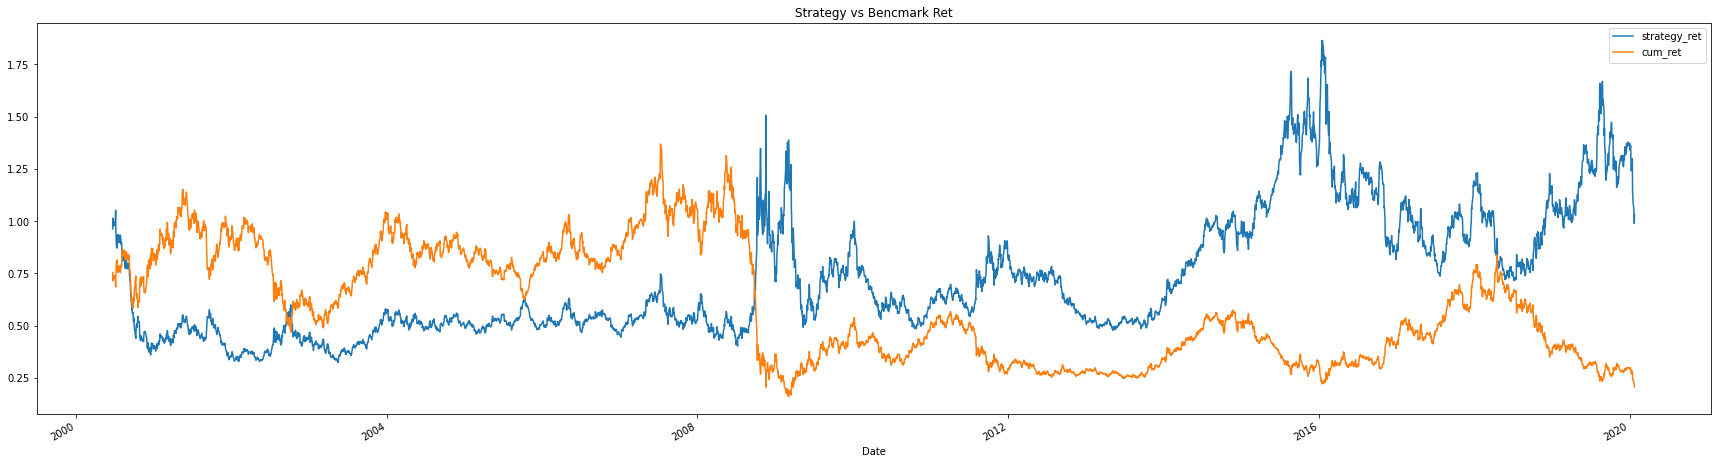

In [ ]:
copy=AA.copy()
copy['pct_change']=copy['Adj Close'].pct_change().shift(-1)
copy['cum_ret']=(1+copy['pct_change']).cumprod() #Benchmark
copy['moving_avg']=copy['Adj Close'].rolling(30).mean()
copy['moving_avglong']=copy['Adj Close'].rolling(120).mean()
copy=copy.dropna()
copy['signal_1']=np.where(copy['moving_avg']>copy['moving_avglong'],1,np.where(copy['moving_avg']<copy['moving_avglong'],-1,0))
copy['strategy_ret']=copy['signal_1']*copy['pct_change']
(1+copy['strategy_ret']).cumprod().plot()
copy['cum_ret'].plot(figsize=(30,8))
#copy[['Adj Close','moving_avg','moving_avglong']].plot(figsize=(30,8))
plt.legend()
plt.title('Strategy vs Bencmark Ret')
plt.show()

In [ ]:
for data in list_stock: #General Parameters
  data['return']=data['Adj Close'].pct_change()
  data['return4']=data['Adj Close'].pct_change(4)
  data['return_next_day']=data['return'].shift(-1)
  data['actual_signal']=np.where(data.return_next_day>0,1,-1) #Optional
  data=data.dropna(inplace=True)

## **Backtesting Portfolio**

In [ ]:
s_portfolio=pd.DataFrame() #Time Series 
f_portfolio=pd.DataFrame()
for data in list_stock:
    s_portfolio=pd.concat([s_portfolio,data[['return_next_day']]],axis=1) #return df
s_portfolio.columns=['AAPL','AA','FORD','TSLA','NFLX'] 
s_portfolio_=s_portfolio.dropna(inplace=True)
for data in list_stock:
    f_portfolio=pd.concat([f_portfolio,data[['return4']]],axis=1) #factors df
f_portfolio.columns=['AAPL','AA','FORD','TSLA','NFLX'] #Change this  depending on your portfolio
f_portfolio_=f_portfolio.dropna(inplace=True)


In [ ]:
cross_s=s_portfolio.T #Cross Sectional
cross_f=f_portfolio.T

In [ ]:
print(cross_s.shape)
print(cross_f.shape)

(5, 111)
(5, 111)


In [ ]:
def ranking_factors_return(d1,d2):
  dailypnl=[]
  i=0
  for m in d1.columns: #Daily
    r=pd.DataFrame()
    r=pd.concat([d1.iloc[:,i],d2.iloc[:,1]],axis=1)
    r.columns=['Returns','Factors']
    r=r.sort_values(by='Factors',ascending=False)
    thres=[.75,.25]
    upper=r.quantile([thres[0],thres[1]],axis=0)['Factors'][thres[0]] #Top 25 Quintile 
    lower=r.quantile([thres[0],thres[1]],axis=0)['Factors'][thres[1]] #Lower 25 Quintile
    retlong=r[r['Factors']>upper]['Returns'].sum()*1 #Long Position
    retshort=r[r['Factors']<lower]['Returns'].sum()*-1 #Short Position
    dailypnl.append(retlong+retshort)
    i+=1
  return dailypnl

In [ ]:
dailypnl=ranking_factors_return(cross_s,cross_f)
pnl=pd.DataFrame(dailypnl,columns=['PnL'])
sharpe=np.mean(pnl['PnL'])/np.std(pnl['PnL'])*np.sqrt(12)
sharpe

0.557201350334964

## **Backtesting Portfolio with TC**

In [ ]:
#Transaction costs
tc_pct=0.01 #Check2
pnl['my_tcs']=pnl['PnL']*tc_pct
pnl['PnL_wTC']=pnl['PnL']-(pnl['my_tcs'] *2* len(f_portfolio.columns)) #Round trip trade and num stocks in portfoliopnl

In [ ]:
sharpeTC=np.mean(pnl['PnL_wTC'])/np.std(pnl['PnL'])*np.sqrt(12)
sharpeTC


0.5014812153014678

## **Advance Backtesting**

In [ ]:
# initialize backtest with dollar amount
Principal = 1000000
Net_Asset_List = [Principal]
# build the initial investment pool
model = Class_(data_dict, p_dict, last_port)
stock_arr, port_arr = model.get_result
init_port = port_arr * Principal
range_list = OpenPrice.columns.to_list() # convert all the trading days to a list
open_price = OpenPrice[range_list[0]].values
holding_shares = init_port / open_price
close_price = Closeprice[range_list[0]].values
temp = holding_shares * close_price
Principal = np.sum(temp) # sum up the net worth each day after the market close
last_port = temp / Principal
Net_Asset_List.append(Principal) # store the net worth of the day
# TODO
# update training set
# Add the close_price, which is a 1-D np.array, to your dataset!
# rolling over each day
# You could set range_list[1:] to range_list[1:20] for test purpose
for idx, date in enumerate(range_list[1:]):
    # model results
    model = Class_(data_dict, p_dict, last_port)
    stock_arr, port_arr = model.get_result
    # change of portfolio
    change_arr = port_arr - last_port  # buy and sell info stored in change_arr
    change_dollars = Principal * change_arr
    open_price = OpenPrice[date].values
    change_shares = change_dollars / open_price
    holding_shares += change_shares
    # calculate the net worth after the market closes
    close_price = Closeprice[date].values
    temp = holding_shares * close_price
    Principal = np.sum(temp) # sum up the net worth each day after the market close
    last_port = temp / Principal
    Net_Asset_List.append(Principal) # store the net worth of the day
    # TODO
    # update training set
    # Add the close_price, which is a 1-D np.array, to your dataset!